In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")

# Introduction

The file output_Navdeep.csv is the cleaned data that we will use. In the Exploratory Data Analysis, we found that logarithm of price has a better distribution than real price in dollar. Therefore, throughout this file, we use the log_price as output and study its relationship with several features using the regression models.

# Read in the data file

In [2]:
df = pd.read_csv("../output_Navdeep.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      4009 non-null   object 
 1   model                      4009 non-null   object 
 2   model_year                 4009 non-null   int64  
 3   fuel_type                  4009 non-null   object 
 4   engine                     4009 non-null   object 
 5   transmission               4009 non-null   object 
 6   ext_col                    4009 non-null   object 
 7   int_col                    4009 non-null   object 
 8   accident                   4009 non-null   int64  
 9   clean_title                4009 non-null   int64  
 10  price                      4009 non-null   float64
 11  years_used                 4009 non-null   int64  
 12  capacity                   4009 non-null   float64
 13  horsepower                 4009 non-null   float

# Examine the features

In [3]:
column_list = df.columns.tolist()
column_list

['brand',
 'model',
 'model_year',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'price',
 'years_used',
 'capacity',
 'horsepower',
 'engine_type',
 'cylinder_count',
 'fuel_injection',
 'mileage_per_year',
 'mileage_sqrt',
 'mileage_with_age',
 'mileage_per_year_with_age',
 'mileage_brand',
 'mileage',
 'speed',
 'brand_category',
 'log_price',
 'power_to_weight_ratio',
 'brand_frequency',
 'model_frequency']

# Select features

The features I will investigate are the following selected_features. 

In [4]:
selected_features = [
 'fuel_type',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'price',
 'cylinder_count',
 'years_used',
 'capacity',
 'horsepower',
 'mileage',
 'mileage_per_year',
 'mileage_sqrt',
 'brand_category',
 'log_price',
]

In [5]:
df = df[selected_features]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fuel_type         4009 non-null   object 
 1   transmission      4009 non-null   object 
 2   ext_col           4009 non-null   object 
 3   int_col           4009 non-null   object 
 4   accident          4009 non-null   int64  
 5   clean_title       4009 non-null   int64  
 6   price             4009 non-null   float64
 7   cylinder_count    4009 non-null   float64
 8   years_used        4009 non-null   int64  
 9   capacity          4009 non-null   float64
 10  horsepower        4009 non-null   float64
 11  mileage           4009 non-null   int64  
 12  mileage_per_year  4009 non-null   float64
 13  mileage_sqrt      4009 non-null   float64
 14  brand_category    4009 non-null   object 
 15  log_price         4009 non-null   float64
dtypes: float64(7), int64(4), object(5)
memory 

# Filter electric cars

Electric cars have fuel type "Electric". Since electric cars contribute very few amount to the dataset, and have many missing features, we will focus on the non-electric cars. 

In [7]:
df['fuel_type'].unique()

array(['Flex Fuel', 'Gasoline', 'Hybrid', 'Electric', 'Diesel'],
      dtype=object)

Next, we split electric cars and normal cars into two dataset. We will only study the non-electric cars and call this dataset df_normal.

In [8]:
df_electric = df[df.fuel_type == 'Electric']
df_normal = df[df.fuel_type != 'Electric']

# Drop outliers for df_normal

We consider the numeric values outside of the range 0.5%-99.5% as outliers. We drop the outliers for the column "price", "mileage", and "years_used". 

In [9]:
price_lower_limit, price_upper_limit = np.percentile(a=df_normal.price,q=[0.5,99.5])
mileage_lower_limit, mileage_upper_limit = np.percentile(a=df_normal.mileage,q=[0.5,99.5])
years_used_lower_limit, years_used_upper_limit = np.percentile(a=df_normal.years_used,q=[0.5,99.5])
print(price_lower_limit,price_upper_limit)
print(mileage_lower_limit,mileage_upper_limit)
print(years_used_lower_limit,years_used_upper_limit)

3500.0 399940.5
464.89000000000004 244162.0
1.0 29.0


Let's look at the shape of the dataset after the dropping. 

In [10]:
df_nm_flt = df_normal[(df_normal.price>price_lower_limit) & (df_normal.price<price_upper_limit)\
                  & (df_normal.mileage>mileage_lower_limit) & (df_normal.mileage<mileage_upper_limit)\
                  & (df_normal.years_used>years_used_lower_limit) & (df_normal.years_used<years_used_upper_limit)]

df_nm_flt.shape

(3560, 16)

# Investigate how transmission types affect price

The picture below is a box plot of price by transmission. We can merge the class "tiptronic" and "other" into "automatic", since they have similar price distributions.

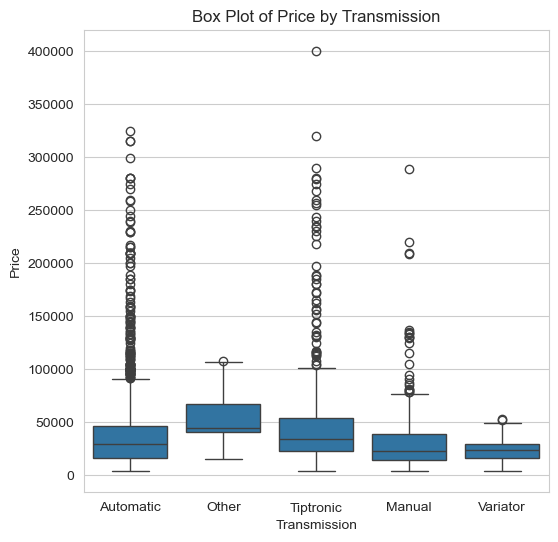

In [11]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='transmission', y='price', data=df_nm_flt)
plt.title('Box Plot of Price by Transmission')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.show()

In [12]:
df_nm_flt['transmission'].value_counts()

transmission
Automatic    2614
Tiptronic     492
Manual        347
Variator       99
Other           8
Name: count, dtype: int64

In [13]:
def convert_transmission(text):
    if text == 'Tiptronic' or text == 'Other': 
        return 'Automatic'
    else:
        return text

In [14]:
df_nm_flt['transmission'] = df_nm_flt['transmission'].apply(convert_transmission)

C:\Users\Song Gao\AppData\Local\Temp\ipykernel_28804\2397040189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nm_flt['transmission'] = df_nm_flt['transmission'].apply(convert_transmission)


In [15]:
df_nm_flt['transmission'].value_counts()

transmission
Automatic    3114
Manual        347
Variator       99
Name: count, dtype: int64

# One-Hot encoder on categorical features

The clean_title and accident columns are already in the form of 0-1 value. We apply one-hot encoder to other categorical columns.

In [16]:
category_features = ["fuel_type",'transmission','ext_col','int_col','brand_category']


In [17]:
dummies = pd.get_dummies(df_nm_flt[category_features],drop_first=True)
df_nm = pd.concat([df_nm_flt, dummies], axis=1).drop(category_features, axis=1)

In [18]:
column_list_nm = df_nm.columns.tolist()
print(len(column_list_nm),column_list_nm)


31 ['accident', 'clean_title', 'price', 'cylinder_count', 'years_used', 'capacity', 'horsepower', 'mileage', 'mileage_per_year', 'mileage_sqrt', 'log_price', 'fuel_type_Flex Fuel', 'fuel_type_Gasoline', 'fuel_type_Hybrid', 'transmission_Manual', 'transmission_Variator', 'ext_col_blue', 'ext_col_gray', 'ext_col_green', 'ext_col_other', 'ext_col_red', 'ext_col_silver', 'ext_col_white', 'int_col_blue', 'int_col_gray', 'int_col_green', 'int_col_other', 'int_col_red', 'int_col_silver', 'int_col_white', 'brand_category_luxury']


# Train test split and KFold split

In [19]:
from sklearn.model_selection import train_test_split

A google result shows that mileage and years_used are the main factors that affect car prices. So first I would like to study to what extent these two factors affect price. That's the reason I make the "continuous_features1". The column list "continuous_features_all" includes all numeric features, and "category_features" include all categorical features except for colors. "Color_features" are the one-hot-encoded color columns.  

In [20]:
continuous_features1 = ['mileage','years_used']
continuous_features_all = ['mileage','years_used','capacity','horsepower','cylinder_count', 'mileage_per_year',
 'mileage_sqrt']
category_features1 = ['accident', 'clean_title','fuel_type_Flex Fuel', 'fuel_type_Gasoline', 'fuel_type_Hybrid', 
                      'transmission_Manual', 'transmission_Variator', 
                       'brand_category_luxury']
color_features = ['ext_col_blue', 'ext_col_gray', 'ext_col_green', 'ext_col_other', 'ext_col_red', 'ext_col_silver', 'ext_col_white', 
                      'int_col_blue', 'int_col_gray', 'int_col_green', 'int_col_other', 'int_col_red', 'int_col_silver', 'int_col_white',]

**Verify there is no missing features** 

Number of columns of df_nm is 31, two of them are price and log_price. So, there are 29 input features in total. 
We check that the above lists include all features. 

In [21]:
len(continuous_features_all)+len(category_features1)+len(color_features)==29

True

Now, it is the point to define input X and output y. We do the train-test split with test_size = 20%. Further, we perform the 5-fold split on the training set for comparing our models. We will determine our best model by error scores and finally use that model to predict on our test set. 

In [22]:
X = df_nm.drop(['price','log_price'], axis=1)
y = df_nm['log_price']

In [23]:
X.shape

(3560, 29)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       test_size = .2)

In [25]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2848, 29) (712, 29) (2848,) (712,)


In [26]:
from sklearn.model_selection import KFold

In [27]:
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 582)

In [28]:
kfold.split(X_train, y_train)

<generator object _BaseKFold.split at 0x000001C7851879A0>

In [29]:
for train_index, test_index in kfold.split(X_train, y_train):
    
    print(len(train_index))
    print(len(test_index))

2278
570
2278
570
2278
570
2279
569
2279
569


# Linear Regression


Before I do this project, Google tells me the most important factors that affect used car price are mileage and years_used. So, in the multilinear regression model "mlr1", I only put mileage and years_used as input features and see what will happen. In the later models (mlr2,mlr3,mlr4,mlr5), I put in more and more numerical and categorical features (up to all features included in mlr5).  The color features turn out to have very slight affect on price, if we compare mlr3 and mlr4. The conclusion is: the mileage and years_used are not the only factors that determine car price. The other features also matter. 

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

In [31]:
mlr1 = LinearRegression()
mlr2 = LinearRegression()
mlr3 = LinearRegression()
mlr4 = LinearRegression()
mlr5 = LinearRegression()


In [ ]:
# rmses_log will hold the cross validation root mean squared errors for log_price of each model. 
# Similarly, we define rmses_real_price and mape_real_price, where "real price" refers to exp(log_price),
#  which is the real price in dollar.
rmses_log = np.zeros((5, 5))
rmses_real_price = np.zeros((5,5))
mape_real_price = np.zeros((5,5))

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    ## get the kfold training data
    X_train_train = X_train.iloc[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train.iloc[test_index,:]
    y_holdout = y_train.iloc[test_index]

    ## Fit all 5 models.
    mlr1.fit(X_train_train[continuous_features1], y_train_train)
    mlr2.fit(X_train_train[continuous_features_all], y_train_train)
    mlr3.fit(X_train_train[continuous_features1+category_features1], y_train_train)
    mlr4.fit(X_train_train[continuous_features1+category_features1+color_features], y_train_train)
    mlr5.fit(X_train_train[continuous_features_all+category_features1+color_features], y_train_train)


    ## Use all 5 models to generate predictions on the holdout set.
    mlr1_preds = mlr1.predict(X_holdout[continuous_features1])
    mlr2_preds = mlr2.predict(X_holdout[continuous_features_all])
    mlr3_preds = mlr3.predict(X_holdout[continuous_features1+category_features1])
    mlr4_preds = mlr4.predict(X_holdout[continuous_features1+category_features1+color_features])
    mlr5_preds = mlr5.predict(X_holdout[continuous_features_all+category_features1+color_features])


    ## Record the rmses and mapes.
    rmses_log[0,i] = root_mean_squared_error(y_holdout, mlr1_preds)
    rmses_real_price[0,i] = root_mean_squared_error(np.exp(y_holdout),np.exp(mlr1_preds))
    mape_real_price[0,i] = mean_absolute_percentage_error(np.exp(y_holdout),np.exp(mlr1_preds))
    rmses_log[1,i] = root_mean_squared_error(y_holdout, mlr2_preds)
    rmses_real_price[1,i] = root_mean_squared_error(np.exp(y_holdout),np.exp(mlr2_preds))
    mape_real_price[1,i] = mean_absolute_percentage_error(np.exp(y_holdout),np.exp(mlr2_preds))
    rmses_log[2,i] = root_mean_squared_error(y_holdout, mlr3_preds)
    rmses_real_price[2,i] = root_mean_squared_error(np.exp(y_holdout),np.exp(mlr3_preds))
    mape_real_price[2,i] = mean_absolute_percentage_error(np.exp(y_holdout),np.exp(mlr3_preds))
    rmses_log[3,i] = root_mean_squared_error(y_holdout, mlr4_preds)
    rmses_real_price[3,i] = root_mean_squared_error(np.exp(y_holdout),np.exp(mlr4_preds))
    mape_real_price[3,i] = mean_absolute_percentage_error(np.exp(y_holdout),np.exp(mlr4_preds))
    rmses_log[4,i] = root_mean_squared_error(y_holdout, mlr5_preds)
    rmses_real_price[4,i] = root_mean_squared_error(np.exp(y_holdout),np.exp(mlr5_preds))
    mape_real_price[4,i] = mean_absolute_percentage_error(np.exp(y_holdout),np.exp(mlr5_preds))



Look at the scores for 5 models and 5 folds.

In [33]:
rmses_log

array([[0.50149147, 0.51142962, 0.52863992, 0.52022706, 0.52611467],
       [0.38700408, 0.40534745, 0.40015277, 0.3897931 , 0.38643774],
       [0.46886952, 0.4819476 , 0.49465107, 0.47426713, 0.49829191],
       [0.46363583, 0.47514646, 0.49428427, 0.47486684, 0.49775636],
       [0.35571687, 0.37849771, 0.37648794, 0.3556282 , 0.36538838]])

In [34]:
rmses_real_price

array([[25776.45025937, 37096.11078599, 31880.24814311, 25951.71120335,
        34300.17696597],
       [22956.38860428, 32774.04822523, 26905.76224103, 21264.05377734,
        29593.62294501],
       [24377.351657  , 35623.10441362, 30271.09518405, 24308.15787345,
        32559.46772529],
       [24275.04217128, 35215.32324148, 30317.99962036, 24480.94116672,
        32357.68376335],
       [20745.96986391, 30944.56072707, 25524.73681151, 19281.85581724,
        27290.45886094]])

In [35]:
mape_real_price

array([[0.41514672, 0.41228899, 0.42424202, 0.43463917, 0.42238056],
       [0.29426058, 0.31073354, 0.30816457, 0.2990716 , 0.28405009],
       [0.39059822, 0.38012642, 0.39801619, 0.39231392, 0.3978404 ],
       [0.38515142, 0.37361576, 0.39694044, 0.39155619, 0.39431402],
       [0.27288372, 0.28173108, 0.29270159, 0.27469581, 0.27049766]])

Next, we take the average of the error scores of the predictions on the 5 hold-out sets for each model.

In [36]:
rmses_log_avg = [0,0,0,0,0]
rmses_real_price_avg = [0,0,0,0,0]
mape_real_price_avg = [0,0,0,0,0]
for i,ls in enumerate(rmses_log):
    rmses_log_avg[i] = np.average(ls)
for i,ls in enumerate(rmses_real_price):
    rmses_real_price_avg[i] = np.average(ls)
for i,ls in enumerate(mape_real_price):
    mape_real_price_avg[i] = np.average(ls)

Finally, the scores for the 5 linear regression models are:

In [37]:
rmses_log_avg

[np.float64(0.517580549232625),
 np.float64(0.39374702967694314),
 np.float64(0.48360544800495375),
 np.float64(0.481137950564449),
 np.float64(0.3663438213748897)]

In [38]:
rmses_real_price_avg

[np.float64(31000.939471554942),
 np.float64(26698.775158577926),
 np.float64(29427.83537068311),
 np.float64(29329.39799263763),
 np.float64(24757.51641613597)]

In [39]:
mape_real_price_avg

[np.float64(0.4217394930297945),
 np.float64(0.29925607663940895),
 np.float64(0.39177903045505863),
 np.float64(0.38831556584144283),
 np.float64(0.2785019711010854)]

We conclude that, the more features we use, the higher accuracy the model have. The best RMSE (real price in dollar) for linear regression model is 24757, and the best MAPE is 27.85%.

# K nearest neighbors

Since knn regression is scale-sensitive, we first apply StandardScaler to the numerical columns, i.e. mileage, years used, capacity, horse power, cylinder count, mileage per year, and square root of mileage. Then we set the parameter k in {2,4,6,8,10,12,14,16,18,20}, and see their performance. 

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [79]:
rmses_log = np.zeros((10,5))
rmses_real_price = np.zeros((10,5))
mape_real_price = np.zeros((10,5))
knn_pipeline = [0]*10
# We set parameter k=2,4,6,8,10,12,14,16,18,20.
for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    for j in range(2,21,2):
        ## get the kfold training data
        X_train_train = X_train.iloc[train_index,:]
        y_train_train = y_train.iloc[train_index]
    
        ## get the holdout data
        X_holdout = X_train.iloc[test_index,:]
        y_holdout = y_train.iloc[test_index]

        knn_j = KNeighborsRegressor(j)
        preprocessor = ColumnTransformer(
            transformers=[('scaler', StandardScaler(), continuous_features_all)],
            remainder='passthrough'
            )
        knn_pipeline[j//2-1] = Pipeline([
            ('preprocessor', preprocessor),
            ('knn_j', knn_j)
            ])

        

        ## Fit knn models with k=2,4,6,8,...,20
        knn_pipeline[j//2-1].fit(X_train_train[continuous_features_all], y_train_train)
        

        ## Use knn models with different parameters k to generate predictions on the holdout set
        knn_j_preds = knn_pipeline[j//2-1].predict(X_holdout[continuous_features_all])
        

        ## Record the rmses
        rmses_log[j//2-1,i] = root_mean_squared_error(y_holdout, knn_j_preds)
        rmses_real_price[j//2-1,i] = root_mean_squared_error(np.exp(y_holdout),np.exp(knn_j_preds))
        mape_real_price[j//2-1,i] = mean_absolute_percentage_error(np.exp(y_holdout),np.exp(knn_j_preds))

        

In [80]:
rmses_log

array([[0.40713645, 0.3949785 , 0.39259278, 0.35741635, 0.37225453],
       [0.36806769, 0.36385102, 0.37708023, 0.34355571, 0.35035916],
       [0.35699164, 0.35822537, 0.37332216, 0.34072397, 0.35055639],
       [0.35495835, 0.35786313, 0.36932844, 0.34134733, 0.34789772],
       [0.35361925, 0.35639717, 0.36655621, 0.34009108, 0.3453214 ],
       [0.35354756, 0.36189917, 0.36888063, 0.34190068, 0.34633862],
       [0.35556516, 0.36314207, 0.36807705, 0.34476392, 0.34765868],
       [0.35526526, 0.36450491, 0.36826275, 0.34840383, 0.34908006],
       [0.35498638, 0.3665375 , 0.36918376, 0.34966215, 0.35039161],
       [0.35291762, 0.36849766, 0.37083241, 0.35083739, 0.35317649]])

In [81]:
rmses_real_price

array([[18091.83414165, 25049.4902821 , 20698.48454828, 16872.09106603,
        22848.53390516],
       [15001.6553386 , 24280.05289257, 21999.28571166, 15278.45501986,
        23340.90730894],
       [15688.72344255, 24647.59376562, 22269.26803312, 15989.75124941,
        24131.6911441 ],
       [16770.72420569, 26183.13535904, 22322.98335224, 16304.34731393,
        24607.62970173],
       [16923.47355825, 27072.42283619, 23087.78713165, 16803.34672834,
        24948.39345679],
       [17476.75958726, 27968.54573974, 23851.7321442 , 17089.66363433,
        25377.3703518 ],
       [17973.07105031, 28666.86390787, 24077.14891718, 17133.13189395,
        25867.81712832],
       [18058.53981459, 29400.54736366, 24278.4750645 , 17737.43326137,
        26145.70695764],
       [18346.17207   , 29959.70136682, 24541.40163006, 17901.62868389,
        26247.38066709],
       [18351.39644303, 30330.79675144, 24925.29952686, 18360.47033683,
        26684.90130818]])

In [82]:
mape_real_price

array([[0.31886188, 0.30977122, 0.29923952, 0.28255328, 0.28750531],
       [0.27837025, 0.28014127, 0.2800937 , 0.26839491, 0.26297254],
       [0.26841436, 0.26975714, 0.27502942, 0.26130427, 0.26133247],
       [0.26864521, 0.26808471, 0.27249949, 0.2580806 , 0.25903016],
       [0.26766192, 0.26520342, 0.27118355, 0.25724703, 0.25633944],
       [0.2665236 , 0.26698894, 0.27124505, 0.25482574, 0.25578407],
       [0.26716106, 0.26358266, 0.27039813, 0.25658751, 0.25564931],
       [0.26688184, 0.26129262, 0.27003751, 0.25807279, 0.25553001],
       [0.26565405, 0.26108325, 0.27059467, 0.25782339, 0.25832311],
       [0.26540903, 0.2622048 , 0.27066471, 0.2578118 , 0.25989239]])

In [83]:
rmses_log_avg = []
rmses_real_price_avg = []
mape_real_price_avg = []
for i,ls in enumerate(rmses_log):
    rmses_log_avg.append((2*(i+1),np.average(ls)))
for i,ls in enumerate(rmses_real_price):
    rmses_real_price_avg.append((2*(i+1),np.average(ls)))
for i,ls in enumerate(mape_real_price):
    mape_real_price_avg.append((2*(i+1),np.average(ls)))

 The list below shows the k values and their corresponding average rmse's. 

In [84]:
rmses_log_avg

[(2, np.float64(0.3848757246538231)),
 (4, np.float64(0.3605827617292061)),
 (6, np.float64(0.3559639050814784)),
 (8, np.float64(0.3542789959547026)),
 (10, np.float64(0.35239702143045254)),
 (12, np.float64(0.3545133297083174)),
 (14, np.float64(0.355841375246254)),
 (16, np.float64(0.3571033601632644)),
 (18, np.float64(0.35815227933017474)),
 (20, np.float64(0.35925231195639307))]

In [85]:
rmses_real_price_avg

[(2, np.float64(20712.086788643952)),
 (4, np.float64(19980.07125432559)),
 (6, np.float64(20545.405526960552)),
 (8, np.float64(21237.76398652534)),
 (10, np.float64(21767.08474224654)),
 (12, np.float64(22352.814291464674)),
 (14, np.float64(22743.606579523912)),
 (16, np.float64(23124.140492351544)),
 (18, np.float64(23399.256883572358)),
 (20, np.float64(23730.572873268662))]

In [86]:
mape_real_price_avg

[(2, np.float64(0.2995862410547612)),
 (4, np.float64(0.27399453527613676)),
 (6, np.float64(0.26716753173698415)),
 (8, np.float64(0.26526803551899664)),
 (10, np.float64(0.263527072293693)),
 (12, np.float64(0.26307348104705147)),
 (14, np.float64(0.2626757348537413)),
 (16, np.float64(0.2623629523559394)),
 (18, np.float64(0.26269569332579723)),
 (20, np.float64(0.2631965439418767))]

# Test Random Forest

We apply the random forest model in the following blocks. We apply GridSearchCV to search for the best parameter of the model. Then calculate the rmse on the 5-fold cross validation. 

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


In [62]:
params = {'n_estimators': [100,150,200],
          'max_features': ['sqrt','log2'],
          'max_depth' : [4,5,6,7],
          'min_samples_split' :[2,3,4,5,6],
          'max_samples': [100,150,200,250]
          }

In [63]:
RFR_cv = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1)
RFR_cv.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [100, 150, 200, 250],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [100, 150, 200]})

In [64]:
best_RFR = RFR_cv.best_estimator_
best_RFR

RandomForestRegressor(max_depth=7, max_features='sqrt', max_samples=250)

In [65]:
best_params = RFR_cv.best_params_
best_params

{'max_depth': 7,
 'max_features': 'sqrt',
 'max_samples': 250,
 'min_samples_split': 2,
 'n_estimators': 100}

In [66]:
# rmses will hold the cross validation root mean squared errors of the best_RFR model. 
rmses_log = np.zeros((1, 5))
rmses_real_price = np.zeros((1, 5))
mape_real_price = np.zeros((1, 5))

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    ## get the kfold training data
    X_train_train = X_train.iloc[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train.iloc[test_index,:]
    y_holdout = y_train.iloc[test_index]

    ## Fit both models
    best_RFR.fit(X_train_train, y_train_train)
    


    ## Use both models to generate predictions on the holdout set
    best_RFR_pred = best_RFR.predict(X_holdout)
    

    ## Record the rmses
    
    rmses_log[0,i] = root_mean_squared_error(y_holdout, best_RFR_pred)

    rmses_real_price[0,i] = root_mean_squared_error(np.exp(y_holdout), np.exp(best_RFR_pred))

    mape_real_price[0,i] = mean_absolute_percentage_error(np.exp(y_holdout), np.exp(best_RFR_pred))

    

In [67]:
np.average(rmses_log)

np.float64(0.374039200973922)

In [68]:
np.average(rmses_real_price)

np.float64(24605.873559042164)

In [69]:
np.average(mape_real_price)

np.float64(0.2900931598435574)

# Conclusion

The above model testings show that K nearest neighbor with k=14 has the best MAPE score, which is 26.27%. We will take K nearest neighbor regressor (k=14) as our final model. 

# Predict on Test Set

In [93]:
knn_pipeline_14 = knn_pipeline[14//2-1]

knn_14_preds = knn_pipeline_14.predict(X_test[continuous_features_all])
        

## Record the scores.
rmse_log_final = root_mean_squared_error(y_test, knn_14_preds)
rmse_real_price_final = root_mean_squared_error(np.exp(y_test),np.exp(knn_14_preds))
mape_real_price_final = mean_absolute_percentage_error(np.exp(y_test),np.exp(knn_14_preds))

In [94]:
print('For real price in dollar, our final RMSE is', rmse_real_price_final, 'and final MAPE is', mape_real_price_final)

For real price in dollar, our final RMSE is 27213.930038964347 and final MAPE is 0.254938916740001
